In [1]:
# Exemplo Fine Tuning de uma VGG16
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import regularizers
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.style as sty

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

import os
import random as rn
import seaborn as sns

import tensorflow as tf
import cv2


In [2]:
#Configurações Arbritarias escolhidas para treinamento
batch_size = 32
num_classes = 10
epochs = 10
W=75
H=75


In [3]:
# load train and test dataset (CIFAR 10)
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # pegando apenas parte das imagens de treinamento devido ao limite de nossa memória
    #Xtr, Xvl, ytr, yvl = train_test_split(trainX, trainY, test_size=.0,random_state=42,stratify=trainY)
    Xtr=trainX
    ytr=trainY
    # one hot encode target values
    nb_train_samples = len(Xtr)
    nb_test_samples = len(testX)
    print(nb_train_samples)
    trainX = np.array([cv2.resize(img, (W,H)) for img in Xtr[:nb_train_samples,:,:,:]])
    testX = np.array([cv2.resize(img, (W,H)) for img in testX[:nb_test_samples,:,:,:]])
#    trainY = to_categorical(ytr)
#    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [4]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [5]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
print(trainX.shape)
print(testX.shape)
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

170498071/170498071 [==============================] - 2s 0us/step
50000
(50000, 75, 75, 3)
(10000, 75, 75, 3)


In [6]:
# Load VGG16 without the top FC Layers.
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
#from keras.applications import InceptionV3

model = DenseNet121(weights='imagenet', include_top=False, pooling='avg', input_shape=(W, H, 3))

train_features=model.predict(trainX)
test_features=model.predict(testX)



313/313 [==============================] - 6s 18ms/step


In [7]:
train_features.shape

(50000, 1024)

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

trainY=np.reshape(trainY, (50000))
testY=np.reshape(testY, (10000))
print(testY)

#clf=GaussianNB()
clf=KNeighborsClassifier(n_neighbors=10)
#clf=SVC(C=100)
clf.fit(train_features, trainY)
score=clf.score(test_features, testY)
print('Accuracy: %.3f' % score)

[3 8 8 ... 5 1 7]
Accuracy: 0.649


In [9]:
print(train_features.shape)
print(test_features.shape)

(50000, 1024)
(10000, 1024)


In [10]:
# Plotar a matrix de confusão 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  
  print(cm)
  
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [11]:
# Predição da CNN
y_predict=clf.predict(test_features)

# Preparar Matriz de Confusão
cm=confusion_matrix(testY, y_predict)

Confusion matrix, without normalization
[[754  20  22   8  37   5  22  10  85  37]
 [ 53 689   7  20  21   2  14   4  53 137]
 [104   8 502  36 151  25 141  18  12   3]
 [ 43  11  78 453  94  94 153  20  32  22]
 [ 42   6  48  47 665  10 132  31  10   9]
 [ 27   8  49 159  79 554  67  43   8   6]
 [ 15   3  44  40  72  16 796   1  12   1]
 [ 48   7  42  38 178  40  18 595   7  27]
 [102  36  21   8  21   4   9   6 725  68]
 [ 55 102   2  10  17   0   8   9  36 761]]


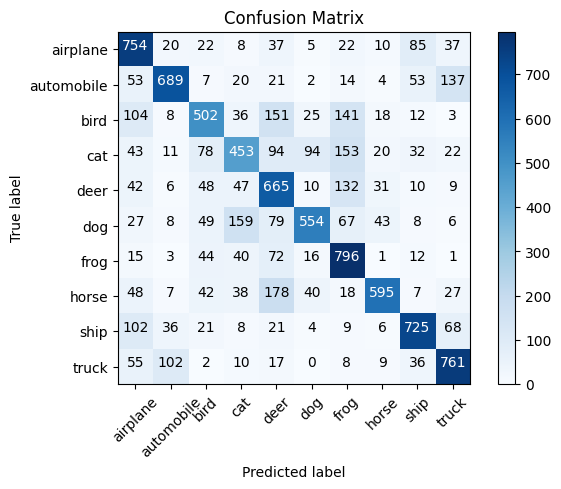

In [12]:
# Chamada da matriz confusão
cm_plot_labels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cm, cm_plot_labels, title= 'Confusion Matrix')
